In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop
from keras.layers import BatchNormalization
from keras.layers import Dropout

from sklearn.decomposition import PCA
from modules.pca_module import perform_pca
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


### 1-Load data

In [2]:
#modify this with the name of the paths to read
outcomes_a = pd.read_csv("data/outcomes/outcomes_a_balanced.csv")
outcomes_b = pd.read_csv("data/outcomes/Outcomes-b.txt")
outcomes_c = pd.read_csv("data/outcomes/Outcomes-c.txt")

outcomes_a = outcomes_a.drop(columns=['SOFA', 'SAPS-I', 'Survival'])
outcomes_b = outcomes_b.drop(columns=['SOFA', 'SAPS-I', 'Survival'])
outcomes_c = outcomes_c.drop(columns=['SOFA', 'SAPS-I', 'Survival'])

# Specify your choice of split for training and testing
choice_train = '_a'  # Choose from '_a', '_b', or '_c' for training
choice_test = '_b'   # Choose from '_a', '_b', or '_c' for testing

In [3]:
knn_df = pd.read_csv('clean_data/withsetc/KNN_imputed_df.csv')
m1_df = pd.read_csv('clean_data/withsetc/minus1_imputed_df.csv')

In [4]:
pd.options.display.max_columns = None
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
3000,140101.0,39.0,0,3,87.337631,1,13.5,3.703704,-0.041667,0.55,9.090909,0.4,0.6,0.0,10.0,0.0,86.0,94.5,103.0,8.994709,-0.708333,33.5,1.492537,32.9,0.0,103.5,122.0,6.763285,-0.435627,3.9,4.05,4.2,3.703704,1.3,7.692308,1.9,1.7,1.9,11.764706,79.94125,105.5375,8.056988,83.0175,0.079813,141.0,0.70922,0.083333,67.67,82.0,5.911039,62.33,0.023729,66.0,76.0,13.636364,0.162983,145.0,139.0,145.0,4.316547,0.900552,7.36,0.271739,164.0,9.146341,1.25,37.7,38.1,0.132626,37.8,60.0,100.0,33.333333,60.0,0.051099,13.25,19.245283,-0.2125,253.0,0.0,6.150326e-16,10,0


In [5]:
knn_df.shape , m1_df.shape

((12000, 83), (12000, 83))

### 2-Look at the distribution target("type") variable
As both df are the same and its difference is the NaN imputation, the outcomes distribution will be the same

In [6]:
knn_df['In-hospital_death'].value_counts()

In-hospital_death
0    10293
1     1707
Name: count, dtype: int64

In [7]:
negative_samples = knn_df['In-hospital_death'].value_counts()[0]
positive_samples = knn_df['In-hospital_death'].value_counts()[1]
total_samples = negative_samples + positive_samples
weight_for_class_0 = total_samples / (negative_samples * 2) 
weight_for_class_1 = total_samples / (positive_samples * 2) 

In [8]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

class WeightedBinaryCrossEntropy(Loss):
    def __init__(self, class_weights):
        super(WeightedBinaryCrossEntropy, self).__init__()
        self.class_weights = class_weights

    def call(self, y_true, y_pred):
        # Cast tensors to float32 to ensure type consistency
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Apply weights to the binary crossentropy loss
        loss = -(self.class_weights * y_true * tf.math.log(y_pred + 1e-10) + (1 - y_true) * tf.math.log(1 - y_pred + 1e-10))
        return tf.reduce_mean(loss)

# Example usage:
class_weights = tf.constant([[weight_for_class_0], [weight_for_class_1]])  # Example weights for the two classes (adjust as needed)
weighted_binary_crossentropy = WeightedBinaryCrossEntropy(class_weights)

# Register the custom loss function
tf.keras.utils.get_custom_objects()['weighted_binary_crossentropy'] = weighted_binary_crossentropy

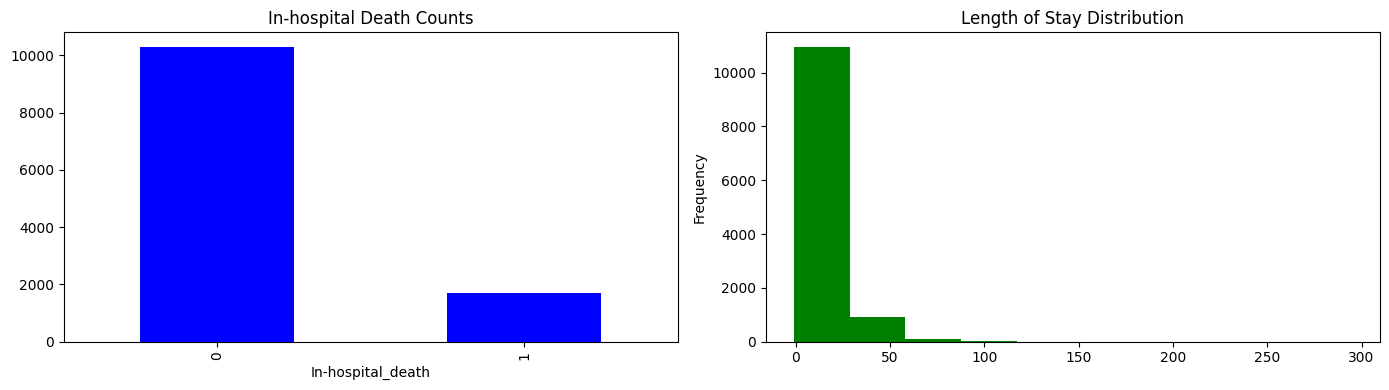

In [9]:
import matplotlib.pyplot as plt

# Create a new figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns for two plots

# Plot the count of each value in the 'In-hospital_death' column as a bar plot
knn_df['In-hospital_death'].value_counts().plot(kind="bar", ax=axs[0], color='blue')

# Plot the distribution of values in the 'Length_of_stay' column as a histogram
knn_df['Length_of_stay'].plot(kind="hist", ax=axs[1], color='green')

# Set titles for each subplot
axs[0].set_title('In-hospital Death Counts')
axs[1].set_title('Length of Stay Distribution')

# Show the plots
plt.tight_layout()
plt.show()


### 3-IN_HOSPITAL_DEATH PREDICTION

**3.1 -Create a function that**
 - remove the outcome columns and palaces RecordID as index
 - splits the data
 - normalizes the data
 - creates / compiles and trains a basic model
 - predicts the outcomes


*FUNCTION PARAMETERS*
- Input layer - 64 nodes, activation ReLu, input features

- Hidden layer - 64 nodes activation ReLu

- Output - 1 node, activation sigmoid

*Optimization and cost for the model*
- loss - "mse" # Mean Squared Error

- optimizer - SGD # Stochastic Gradient Descent

- metrics - "mae" # Mean average error  

In order to keep all the results we will save them to finally summarize in a df

In [10]:
# Create a df to save the results
data = {
    "Model": [],
    "Method": [],
    "mean_precision": [],
    "mean_recall": [],
    "stdev_precision": [],
    "stdev_recall": []
}

df_results = pd.DataFrame(data)


In [11]:
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
443,133659.0,46.0,1,1,31.632716,1,12.0,16.666667,-0.195397,0.7,0.0,0.49275,0.654875,4.636844,15.0,0.0,95.0,95.0,101.0,5.263158,0.073947,26.0,0.0,36.9,2.03252,83.0,116.5,4.819277,0.10556,4.1,3.8,4.1,5.263158,2.144075,11.625837,2.0,2.0,2.1,5.0,77.0,90.0,5.194805,88.0,0.258696,137.0,1.459854,0.135651,83.67,90.5,1.995936,84.0,-0.006785,40.62875,47.19,6.151016,-0.014691,121.495,141.85125,246.4125,16.902651,-5.014327,7.614237,0.744618,194.5,7.197943,-1.732601,36.7,36.9,0.544959,36.9,210.0,530.0,50.0,375.0,7.102528,7.9,6.329114,-0.1024,100.0,0.0,0.044868,4,0


In [12]:
def f1_scorer(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)  # Convert probabilities to binary predictions

    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Replace NaN values with zeros

    return tf.reduce_mean(f1)

In [13]:
def NN_basic_model(df, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test):
    """
    Builds and trains a basic neural network model for binary classification.

    Args:
        df (pd.DataFrame): Input DataFrame containing features and target variable.
        outcomes_a (str): outcomes for split A.
        outcomes_b (str): outcomes for split B.
        outcomes_c (str): outcomes for split C
        choice_train (str): Name of the df split to use for training data.
        choice_test (str): Name of the df split to use for testing data.


    Returns:
        float: F1-score on the test set.
    """
    df = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    df_outcomes_a_df = pd.merge(df, outcomes_a, on="RecordID", how="inner")
    df_outcomes_b_df = pd.merge(df, outcomes_b, on="RecordID", how="inner")
    df_outcomes_c_df = pd.merge(df, outcomes_c, on="RecordID", how="inner")

    # Extract features and target variable
    # Extract features and target variable
    # For training set X_train and y_train
    X_a = df_outcomes_a_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y_a = df_outcomes_a_df['In-hospital_death']

    # For testing set B X_test_b and y_test_b
    X_b = df_outcomes_b_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y_b = df_outcomes_b_df['In-hospital_death']

    # For testing set C X_test_c and y_test_c
    X_c = df_outcomes_c_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y_c = df_outcomes_c_df['In-hospital_death']

    # Define a dictionary to store the splits
    data_splits = {'_a': (X_a, y_a), '_b': (X_b, y_b), '_c': (X_c, y_c)}

    # Get the selected splits for training and testing
    X_train, y_train = data_splits[choice_train]
    X_test, y_test = data_splits[choice_test]

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=[f1_scorer, "accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
 
    precision = precision_score(y_test, y_pred_binary)
    print(f"precision on test set: {precision:.2f}")
    recall = recall_score(y_test, y_pred_binary)
    print(f"recall on test set: {recall:.2f}")
    f1 = f1_score(y_test, y_pred_binary)
    print(f"f1 score on test set: {f1:.2f}")
    
    return y_test, y_pred_binary

**3.2- Evaluation of the model performance on the two loaded dataframes**

in order to have more information we will run each model 10 times

In [14]:
def run_function_10_times(df, function, *args, **kwargs):
    precision = []
    recall = []
    for i in range(10):   
        y_test, y_pred = function(df, *args, **kwargs)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        precision.append(prec)
        recall.append(rec)
    return np.mean(precision), np.mean(recall), np.std(precision), np.std(recall)

In [15]:
mean_prec, mean_rec, stdev_prec, stdev_recall =  run_function_10_times(knn_df, NN_basic_model, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test)


Epoch 1/20


35/35 [==============================] - 1s 2ms/step - loss: 0.5410 - f1_scorer: 0.7368 - accuracy: 0.7292
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3685 - f1_scorer: 0.8428 - accuracy: 0.8466
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3160 - f1_scorer: 0.8748 - accuracy: 0.8764
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2794 - f1_scorer: 0.8858 - accuracy: 0.8881
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2538 - f1_scorer: 0.9064 - accuracy: 0.9070
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2336 - f1_scorer: 0.9045 - accuracy: 0.9052
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2233 - f1_scorer: 0.9154 - accuracy: 0.9161
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1940 - f1_scorer: 0.9180 - accuracy: 0.9188
Epoch 9/20
35/35 [==============================] - 0

In [16]:
print(f"basic_NN for Knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "knn_df"
df_results.loc[0] = [Model, method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_results

basic_NN for Knn_df : mean_prec = 0.2126974355060168, mean_rec =  0.8794014084507042, stdev_prec = 0.005453414381578369, stdev_recall = 0.006552040164059301


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_basic,knn_df,0.212697,0.879401,0.005453,0.006552


In [17]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, NN_basic_model, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test)

Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3009 - f1_scorer: 0.8626 - accuracy: 0.8836
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1903 - f1_scorer: 0.9267 - accuracy: 0.9296
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1723 - f1_scorer: 0.9335 - accuracy: 0.9377
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1643 - f1_scorer: 0.9463 - accuracy: 0.9495
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1635 - f1_scorer: 0.9346 - accuracy: 0.9413
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1576 - f1_scorer: 0.9415 - accuracy: 0.9449
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1303 - f1_scorer: 0.9538 - accuracy: 0.9549
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1297 - f1_scorer: 0.9429 - accuracy: 0.9477
Epoch 9/20
35/35 [==============================] - 0s 1

In [18]:
print(f"basic_NN for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "m1_df"
df_results.loc[1] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN for m1_df : mean_prec = 0.1680961707153308, mean_rec =  0.934507042253521, stdev_prec = 0.0008067035373653984, stdev_recall = 0.006139294286677002


**3.3 -Use PCA in the models to check for improvement.**

As PCA already requieres standarization of numerica features a new function must be created but the model will be the same. 

In [19]:
def NN_PCA_model(df, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test):
    """
    Builds and trains an improved neural network model for binary classification using PCA.
   
    Args:
        df (pd.DataFrame): Input DataFrame containing features and target variable.
        outcomes_a (str): outcomes for split A.
        outcomes_b (str): outcomes for split B.
        outcomes_c (str): outcomes for split C
        choice_train (str): Name of the df split to use for training data.
        choice_test (str): Name of the df split to use for testing data.


    Returns:
        float: F1-score on the test set.
    """
    df = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    df_outcomes_a_df = pd.merge(df, outcomes_a, on="RecordID", how="inner")
    df_outcomes_b_df = pd.merge(df, outcomes_b, on="RecordID", how="inner")
    df_outcomes_c_df = pd.merge(df, outcomes_c, on="RecordID", how="inner")

    # Extract features and target variable
    # Extract features and target variable
    # For training set X_train and y_train
    X_a = df_outcomes_a_df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y_a = df_outcomes_a_df['In-hospital_death']

    # For testing set B X_test_b and y_test_b
    X_b = df_outcomes_b_df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y_b = df_outcomes_b_df['In-hospital_death']

    # For testing set C X_test_c and y_test_c
    X_c = df_outcomes_c_df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y_c = df_outcomes_c_df['In-hospital_death']

    # Define a dictionary to store the splits
    data_splits = {'_a': (X_a, y_a), '_b': (X_b, y_b), '_c': (X_c, y_c)}

    # Get the selected splits for training and testing
    X_train, y_train = data_splits[choice_train]
    X_test, y_test = data_splits[choice_test]

    #exclude categorical features from PCA transformation
    categorical_features = ['Gender', 'ICUType', 'MechVent']
    X_train, X_test, pca, explained_variance_ratio = perform_pca(train_data = X_train, test_data = X_test, n_components=0.95, categorical_features=categorical_features)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return y_test, y_pred_binary



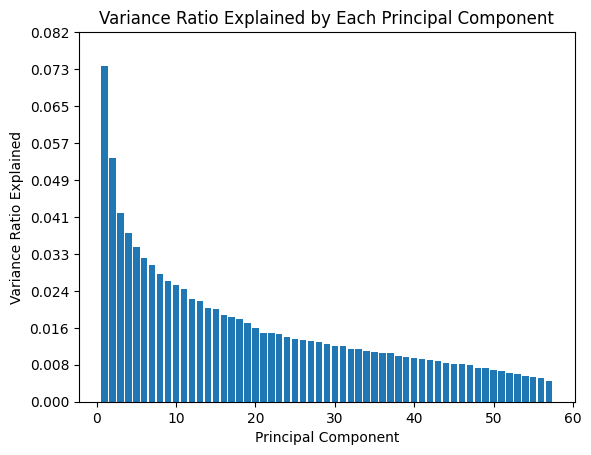

Number of components required to achieve 0.95 variance explained: 57
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5682 - accuracy: 0.7049
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3864 - accuracy: 0.8312
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3479 - accuracy: 0.8502
Epoch 4/20
35/35 [==============================] - 0s 2ms/step - loss: 0.3061 - accuracy: 0.8773
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2702 - accuracy: 0.8881
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2603 - accuracy: 0.8917
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2222 - accuracy: 0.9088
Epoch 8/20
35/35 [==============================] - 0s 2ms/step - loss: 0.2189 - accuracy: 0.9097
Epoch 9/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1911 - accuracy: 0.9224
Epoch 10/20
35/35 [==============================

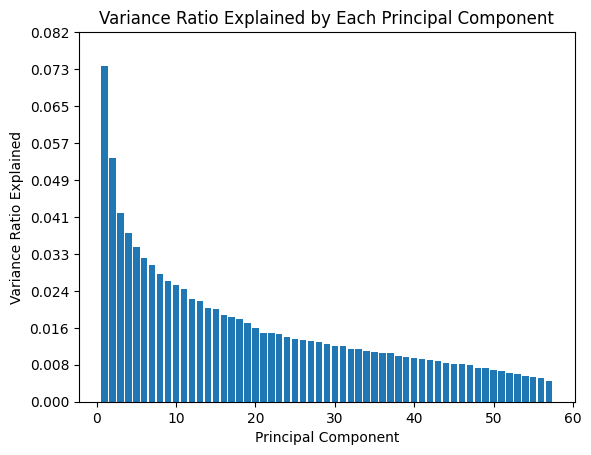

Number of components required to achieve 0.95 variance explained: 57
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5393 - accuracy: 0.7356
Epoch 2/20
35/35 [==============================] - 0s 2ms/step - loss: 0.3720 - accuracy: 0.8439
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3189 - accuracy: 0.8655
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3006 - accuracy: 0.8745
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2683 - accuracy: 0.8908
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2513 - accuracy: 0.9016
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2316 - accuracy: 0.9070
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2062 - accuracy: 0.9143
Epoch 9/20
35/35 [==============================] - 0s 2ms/step - loss: 0.2094 - accuracy: 0.9188
Epoch 10/20
35/35 [==============================

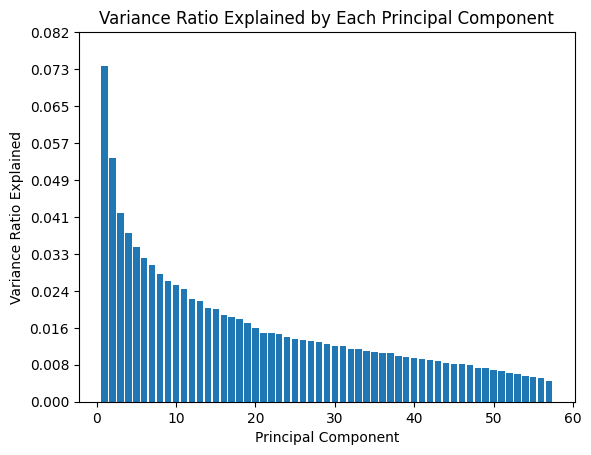

Number of components required to achieve 0.95 variance explained: 57
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5314 - accuracy: 0.7310
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3748 - accuracy: 0.8357
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3216 - accuracy: 0.8646
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2898 - accuracy: 0.8764
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2627 - accuracy: 0.8872
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2362 - accuracy: 0.9088
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2129 - accuracy: 0.9079
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2071 - accuracy: 0.9179
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1958 - accuracy: 0.9197
Epoch 10/20
35/35 [==============================

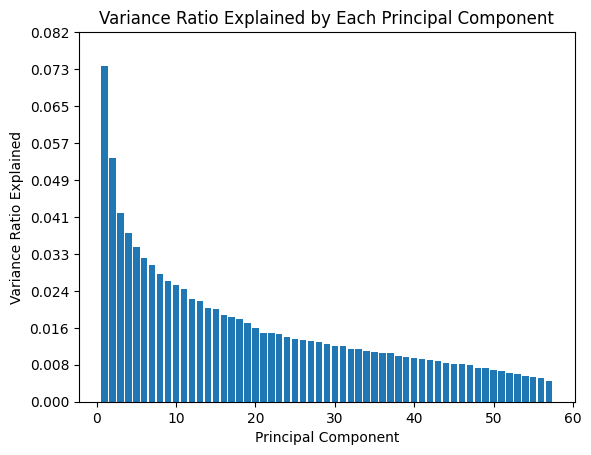

Number of components required to achieve 0.95 variance explained: 57
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5690 - accuracy: 0.7202
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3781 - accuracy: 0.8375
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3248 - accuracy: 0.8601
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2956 - accuracy: 0.8800
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2557 - accuracy: 0.9025
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2325 - accuracy: 0.9034
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2303 - accuracy: 0.9079
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2100 - accuracy: 0.9116
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2072 - accuracy: 0.9116
Epoch 10/20
35/35 [==============================

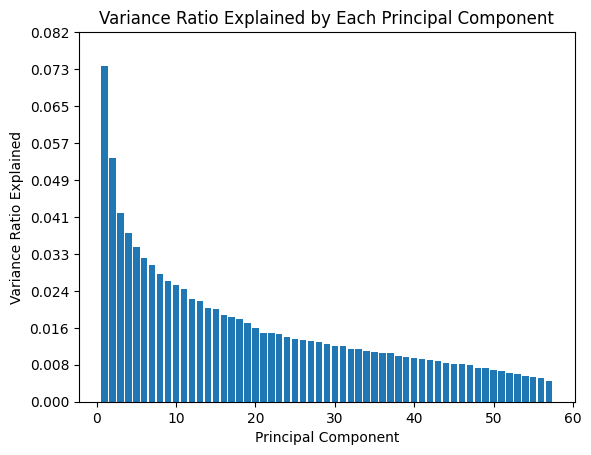

Number of components required to achieve 0.95 variance explained: 57
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5397 - accuracy: 0.7283
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3728 - accuracy: 0.8475
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3348 - accuracy: 0.8556
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2944 - accuracy: 0.8791
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2685 - accuracy: 0.8935
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2576 - accuracy: 0.8908
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2433 - accuracy: 0.9034
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2374 - accuracy: 0.8962
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2067 - accuracy: 0.9125
Epoch 10/20
35/35 [==============================

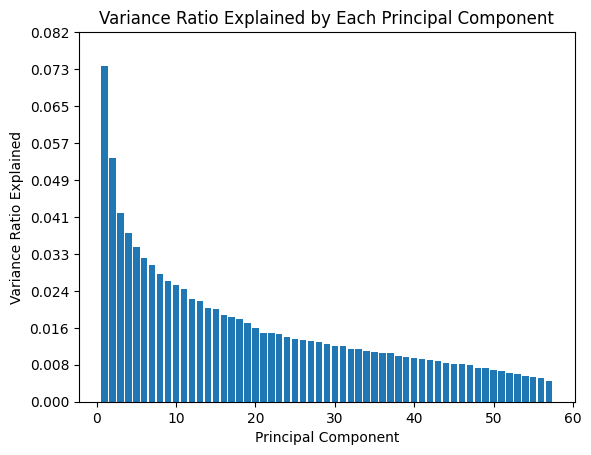

Number of components required to achieve 0.95 variance explained: 57
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5540 - accuracy: 0.7175
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3924 - accuracy: 0.8384
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3399 - accuracy: 0.8700
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3006 - accuracy: 0.8764
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2664 - accuracy: 0.8890
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2729 - accuracy: 0.8917
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2505 - accuracy: 0.9043
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2228 - accuracy: 0.9088
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2231 - accuracy: 0.9061
Epoch 10/20
35/35 [==============================

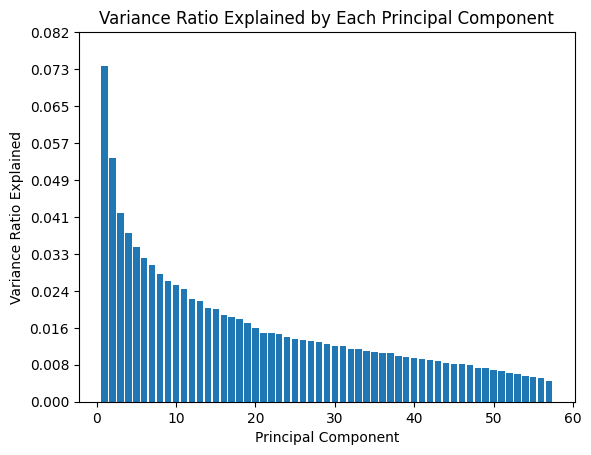

Number of components required to achieve 0.95 variance explained: 57
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5761 - accuracy: 0.7031
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.4051 - accuracy: 0.8258
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3321 - accuracy: 0.8583
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2897 - accuracy: 0.8800
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2846 - accuracy: 0.8809
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2702 - accuracy: 0.8899
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2278 - accuracy: 0.9061
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2256 - accuracy: 0.9125
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2095 - accuracy: 0.9188
Epoch 10/20
35/35 [==============================

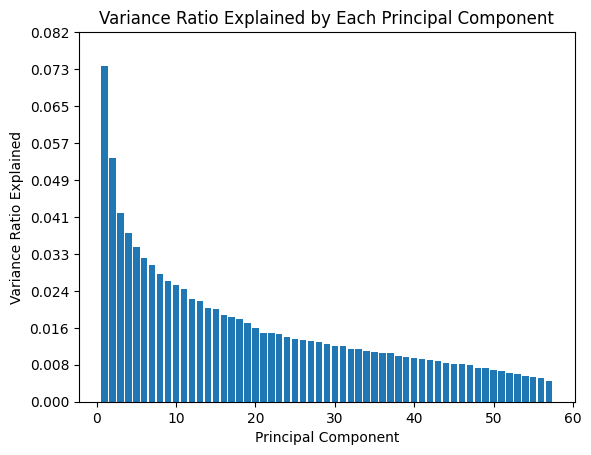

Number of components required to achieve 0.95 variance explained: 57
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5372 - accuracy: 0.7184
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3893 - accuracy: 0.8321
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3359 - accuracy: 0.8592
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3116 - accuracy: 0.8682
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2927 - accuracy: 0.8791
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2396 - accuracy: 0.8989
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2326 - accuracy: 0.9079
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2187 - accuracy: 0.9097
Epoch 9/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1989 - accuracy: 0.9179
Epoch 10/20
35/35 [==============================

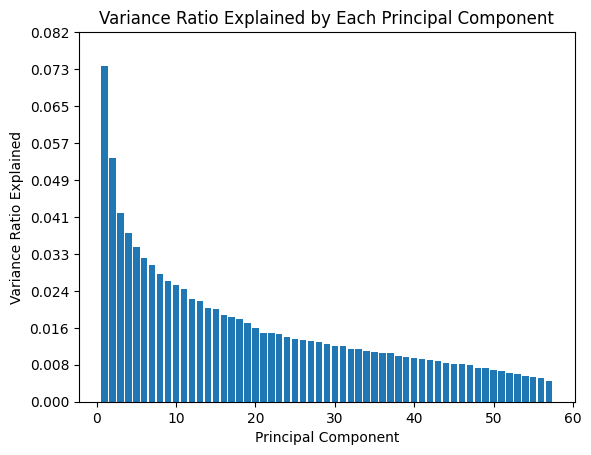

Number of components required to achieve 0.95 variance explained: 57
Epoch 1/20
35/35 [==============================] - 1s 1ms/step - loss: 0.5279 - accuracy: 0.7446
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3687 - accuracy: 0.8439
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3456 - accuracy: 0.8592
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2805 - accuracy: 0.8709
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2938 - accuracy: 0.8809
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2603 - accuracy: 0.8971
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2205 - accuracy: 0.9134
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2021 - accuracy: 0.9188
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2120 - accuracy: 0.9188
Epoch 10/20
35/35 [==============================

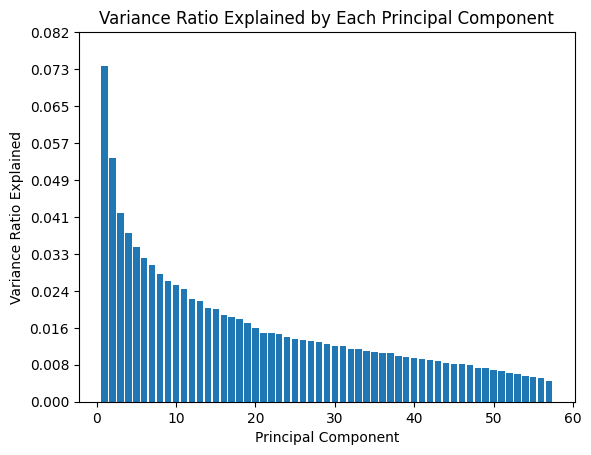

Number of components required to achieve 0.95 variance explained: 57
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.5206 - accuracy: 0.7491
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3670 - accuracy: 0.8312
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3331 - accuracy: 0.8637
Epoch 4/20
35/35 [==============================] - 0s 2ms/step - loss: 0.2799 - accuracy: 0.8881
Epoch 5/20
35/35 [==============================] - 0s 3ms/step - loss: 0.2458 - accuracy: 0.8980
Epoch 6/20
35/35 [==============================] - 0s 2ms/step - loss: 0.2431 - accuracy: 0.9016
Epoch 7/20
35/35 [==============================] - 0s 2ms/step - loss: 0.2484 - accuracy: 0.8944
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2034 - accuracy: 0.9242
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2025 - accuracy: 0.9134
Epoch 10/20
35/35 [==============================

In [20]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df,NN_PCA_model, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test)

In [21]:
print(f"basic_NN_PCA for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "PCA_knn_df"
df_results.loc[2] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_results

basic_NN_PCA for knn_df : mean_prec = 0.21707371548796212, mean_rec =  0.8625, stdev_prec = 0.005753867500860912, stdev_recall = 0.02695962379587732


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_basic,knn_df,0.212697,0.879401,0.005453,0.006552
1,NN_basic,m1_df,0.168096,0.934507,0.000807,0.006139
2,NN_basic,PCA_knn_df,0.217074,0.862500,0.005754,0.026960


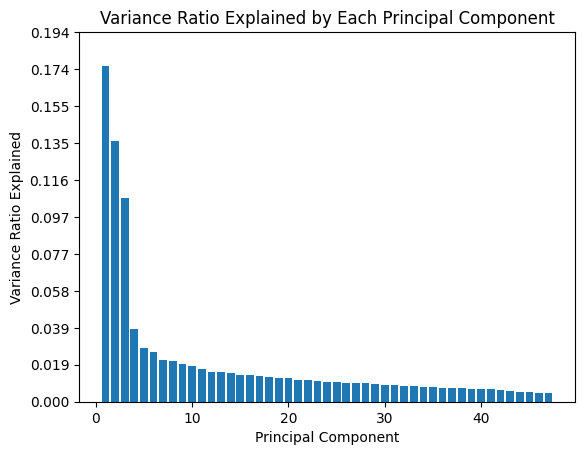

Number of components required to achieve 0.95 variance explained: 47
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3229 - accuracy: 0.8709
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2150 - accuracy: 0.9251
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1881 - accuracy: 0.9287
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1830 - accuracy: 0.9377
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1563 - accuracy: 0.9486
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1545 - accuracy: 0.9404
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1361 - accuracy: 0.9468
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1554 - accuracy: 0.9395
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1520 - accuracy: 0.9413
Epoch 10/20
35/35 [==============================

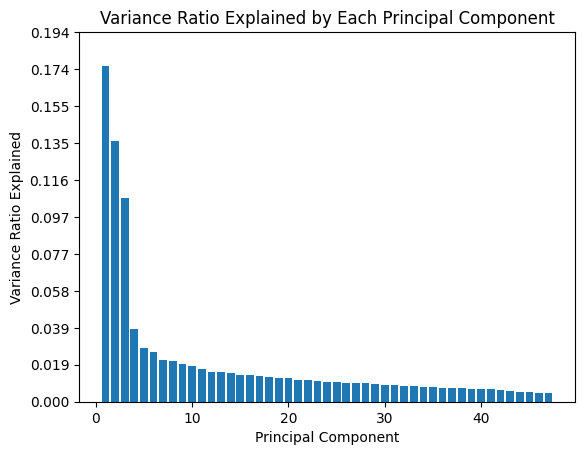

Number of components required to achieve 0.95 variance explained: 47
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3182 - accuracy: 0.8809
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1954 - accuracy: 0.9305
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1746 - accuracy: 0.9404
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1656 - accuracy: 0.9386
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1690 - accuracy: 0.9431
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1667 - accuracy: 0.9377
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1467 - accuracy: 0.9477
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1303 - accuracy: 0.9585
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1360 - accuracy: 0.9540
Epoch 10/20
35/35 [==============================

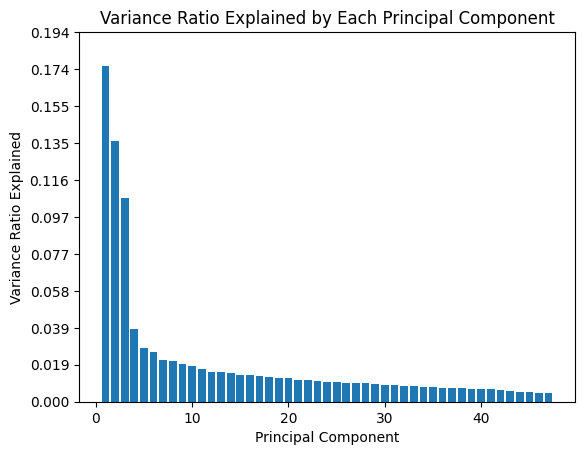

Number of components required to achieve 0.95 variance explained: 47
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3362 - accuracy: 0.8773
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2139 - accuracy: 0.9269
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1805 - accuracy: 0.9377
Epoch 4/20
35/35 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.9359
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1776 - accuracy: 0.9377
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1587 - accuracy: 0.9449
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1586 - accuracy: 0.9440
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1395 - accuracy: 0.9513
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1260 - accuracy: 0.9558
Epoch 10/20
35/35 [==============================

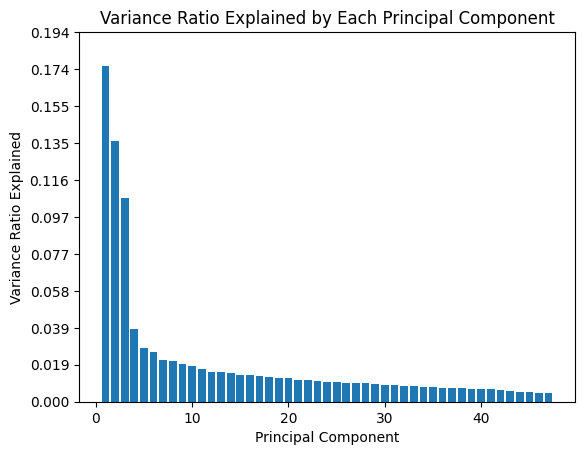

Number of components required to achieve 0.95 variance explained: 47
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3204 - accuracy: 0.8818
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2027 - accuracy: 0.9242
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1929 - accuracy: 0.9368
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1838 - accuracy: 0.9368
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1552 - accuracy: 0.9431
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1547 - accuracy: 0.9413
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1431 - accuracy: 0.9458
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1472 - accuracy: 0.9458
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1438 - accuracy: 0.9449
Epoch 10/20
35/35 [==============================

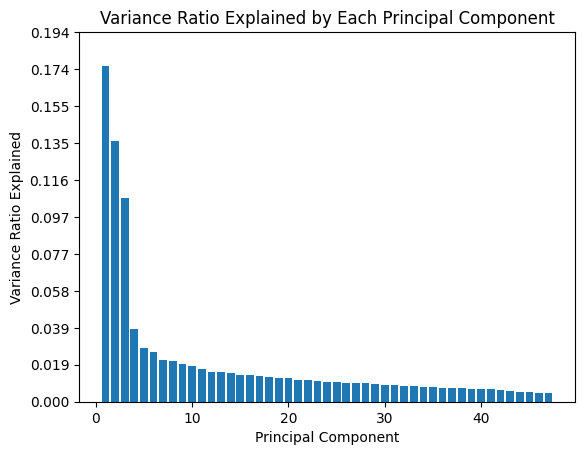

Number of components required to achieve 0.95 variance explained: 47
Epoch 1/20
35/35 [==============================] - 1s 1ms/step - loss: 0.3230 - accuracy: 0.8592
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2161 - accuracy: 0.9215
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1836 - accuracy: 0.9323
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1760 - accuracy: 0.9449
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1652 - accuracy: 0.9386
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1559 - accuracy: 0.9422
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1458 - accuracy: 0.9458
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1486 - accuracy: 0.9458
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1287 - accuracy: 0.9504
Epoch 10/20
35/35 [==============================

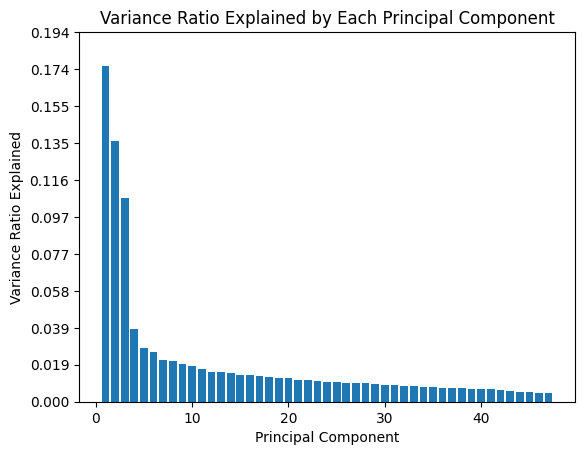

Number of components required to achieve 0.95 variance explained: 47
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3421 - accuracy: 0.8899
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2166 - accuracy: 0.9206
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1866 - accuracy: 0.9359
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1694 - accuracy: 0.9341
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1671 - accuracy: 0.9413
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1691 - accuracy: 0.9404
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1441 - accuracy: 0.9477
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1523 - accuracy: 0.9431
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1488 - accuracy: 0.9504
Epoch 10/20
35/35 [==============================

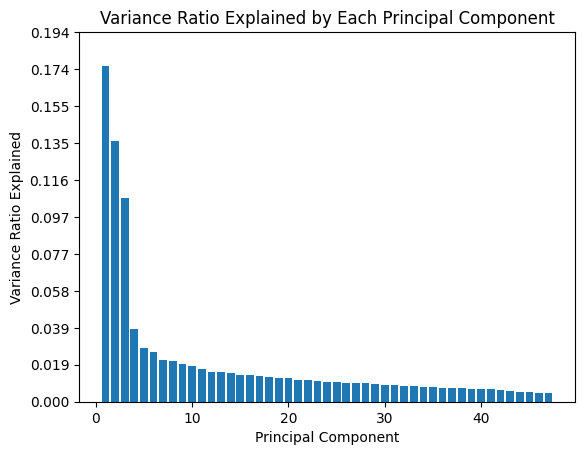

Number of components required to achieve 0.95 variance explained: 47
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3373 - accuracy: 0.8854
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2059 - accuracy: 0.9197
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1811 - accuracy: 0.9341
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1752 - accuracy: 0.9305
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1513 - accuracy: 0.9413
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1553 - accuracy: 0.9440
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1409 - accuracy: 0.9458
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1486 - accuracy: 0.9458
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1308 - accuracy: 0.9558
Epoch 10/20
35/35 [==============================

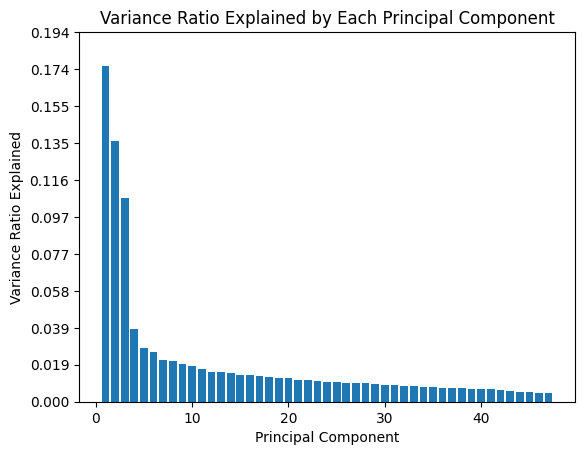

Number of components required to achieve 0.95 variance explained: 47
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3246 - accuracy: 0.8782
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2137 - accuracy: 0.9233
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1822 - accuracy: 0.9404
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1679 - accuracy: 0.9395
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1734 - accuracy: 0.9341
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1567 - accuracy: 0.9440
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1643 - accuracy: 0.9422
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1374 - accuracy: 0.9504
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1406 - accuracy: 0.9477
Epoch 10/20
35/35 [==============================

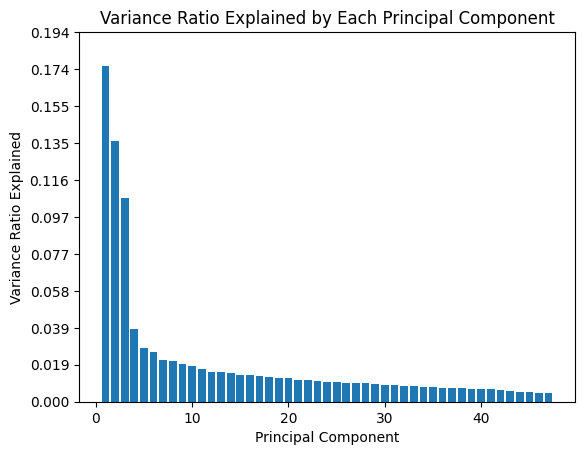

Number of components required to achieve 0.95 variance explained: 47
Epoch 1/20
35/35 [==============================] - 0s 2ms/step - loss: 0.3314 - accuracy: 0.8601
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2183 - accuracy: 0.9179
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1943 - accuracy: 0.9278
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1781 - accuracy: 0.9395
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1691 - accuracy: 0.9323
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1682 - accuracy: 0.9431
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1498 - accuracy: 0.9449
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1364 - accuracy: 0.9513
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1386 - accuracy: 0.9468
Epoch 10/20
35/35 [==============================

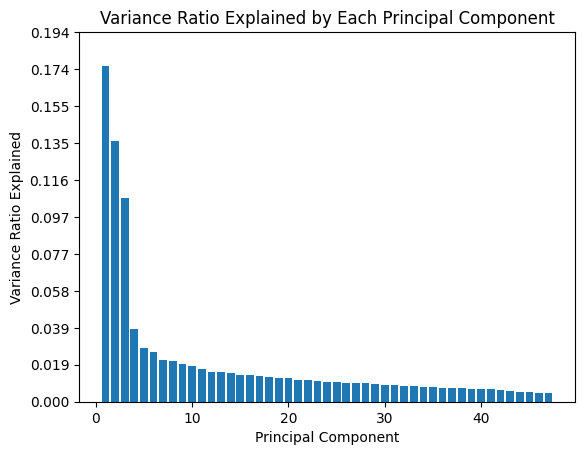

Number of components required to achieve 0.95 variance explained: 47
Epoch 1/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3366 - accuracy: 0.8601
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1953 - accuracy: 0.9314
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1776 - accuracy: 0.9377
Epoch 4/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1640 - accuracy: 0.9350
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1510 - accuracy: 0.9495
Epoch 6/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1448 - accuracy: 0.9458
Epoch 7/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1490 - accuracy: 0.9431
Epoch 8/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1322 - accuracy: 0.9540
Epoch 9/20
35/35 [==============================] - 0s 1ms/step - loss: 0.1392 - accuracy: 0.9477
Epoch 10/20
35/35 [==============================

In [22]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df,NN_PCA_model, outcomes_a, outcomes_b, outcomes_c, choice_train, choice_test)

In [23]:
print(f"basic_NN_PCA for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_basic'
method_name = "PCA_m1_df"
df_results.loc[3] = [Model, method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_PCA for m1_df : mean_prec = 0.16788111532429542, mean_rec =  0.927112676056338, stdev_prec = 0.0008769924678733613, stdev_recall = 0.005742783954331001


In [24]:
df_NN_unders_a_vs_b= df_results
df_NN_unders_a_vs_b

,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_basic,knn_df,0.212697,0.879401,0.005453,0.006552
1,NN_basic,m1_df,0.168096,0.934507,0.000807,0.006139
2,NN_basic,PCA_knn_df,0.217074,0.862500,0.005754,0.026960
3,NN_basic,PCA_m1_df,0.167881,0.927113,0.000877,0.005743
